# Check for Packages

In [ ]:
import IPython
print('IPython:', IPython.__version__)

import pkg_resources
for pkg in ['numpy', 'matplotlib', 'torch', 'torchvision']:
    print(pkg + ':', pkg_resources.get_distribution(pkg).version)

IPython: 5.5.0
numpy: 1.16.4
matplotlib: 3.0.3
torch: 1.1.0
torchvision: 0.3.0


# Problem Background
Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

Here's an example how the data looks (each class takes three-rows):
![alt_text](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)

The original MNIST dataset contains a lot of handwritten digits. Members of the AI/ML/Data Science community love this dataset and use it as a benchmark to validate their algorithms. In fact, MNIST is often the first dataset researchers try. "If it doesn't work on MNIST, it won't work at all", they said. "Well, if it does work on MNIST, it may still fail on others."

(taken from [here](https://github.com/zalandoresearch/fashion-mnist))

# Data Description

| Label | Description |
| :---: | ----- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

# Benchmarking
These are the current reported 3 best classification results, taken from the same link as above.

| Classifier | Preprocessing | Test Accuracy |
| ----- | ----- | :---: |
| [WRN40-4 8.9M params](https://github.com/ajbrock/FreezeOut) | standard preprocessing (mean/std subtraction/division) and augmentation (random crops/horizontal flips) | 0.967 |
| [WRN-28-10 + Random Erasing](https://github.com/zhunzhong07/Random-Erasing) | standard preprocessing (mean/std subtraction/division) and augmentation (random crops/horizontal flips) | 0.963 |
| [WRN-28-10](https://github.com/zhunzhong07/Random-Erasing)	| standard preprocessing (mean/std subtraction/division) and augmentation (random crops/horizontal flips) | 0.959 |

# Load the Data
The Fashion-MNIST dataset is available in torchvision. The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math, random, copy
from collections import *
from time import time

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.model_zoo import load_url as load_state_dict_from_url
from torchvision import utils, models, transforms
from torchvision.datasets import FashionMNIST

In [ ]:
np.random.seed(123);
random.seed(123);
torch.manual_seed(123);

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu");

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = FashionMNIST(root = './data', train = True, download = True, transform = transform)
trainloader = DataLoader(trainset, batch_size = 32, shuffle = True, num_workers = 2)

testset = FashionMNIST(root = './data', train = False, download = True, transform = transform)
testloader = DataLoader(testset, batch_size = 32, shuffle = False, num_workers = 2)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
labeldict = dict(zip(range(10), classes))

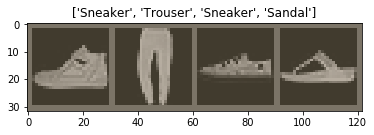

In [ ]:
def imshow(inp, title = None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.01)  # pause a bit so that plots are updated

# Get some training data
example_data = random.sample(range(60000), 4)
images, labels = [trainset[i][0] for i in example_data], [trainset[i][1] for i in example_data]

# Make a grid from the example datas
out = utils.make_grid(images)

imshow(out, title = [labeldict[x] for x in labels])

# Define Model Training Procedure

In [ ]:
dataloaders = {'train': trainloader,
               'val'  : testloader}
dataset_sizes = {'train': len(trainset),
                 'val'  : len(testset)}

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
    start = time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0

    for epoch in range(num_epochs):
        to_print = 'Epoch {}: '.format(str(' ' if epoch < 9 else '') + str(epoch + 1) + '/' + str(num_epochs))

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                to_print += ', '
                model.eval()   # Set model to evaluate mode

            running_loss = 0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            to_print += '{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print(to_print)

    time_elapsed = time() - start
    print('\nTraining complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Multi-Layer Perceptron

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.LogSoftmax(dim = 1)
        )

    def forward(self, input_tensor):
        x = input_tensor.view(-1, 28*28)
        return self.model(x)

print(MLP())

MLP(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
    (5): LogSoftmax()
  )
)


# Convolutional Neural Network

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size = 5, padding = 2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size = 5, padding = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7*7*32, 10)

    def forward(self, input_tensor):
        x = self.layer1(input_tensor)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

print(CNN())

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


# Torchvision Models
The following models are taken from predefined model architectures in the Torchvision package called from [torchvision.models](https://pytorch.org/docs/stable/torchvision/models.html). However these models take in an input of RGB hex coloring, therefore 3 channels. All we need to do is to take the source codes for these predefined models and tweak the models to take in an input of grayscale coloring, which is 1 channel. This is the only necessary tweak and we'll leave the rest of the source code as is.

We will explore these models:
* AlexNet
* VGG
* ResNet
* SqueezeNet
* DenseNet
* **Inception v3**
* **GoogLeNet**
* **ShuffleNet v2**
* MobileNet v2
* ResNeXt
* **WideResNet**

and measure their performance, starting with VGG16, ResNet 18, ResNet 50, and ResNet 152. The models in bold will be checked out in a different section.

In [ ]:
nets = np.array([model for model in dir(models) if model[0] != '_'])
nets = np.setdiff1d(nets, 'utils')
nets

array(['AlexNet', 'DenseNet', 'GoogLeNet', 'Inception3', 'MobileNetV2',
       'ResNet', 'ShuffleNetV2', 'SqueezeNet', 'VGG', 'alexnet',
       'densenet', 'densenet121', 'densenet161', 'densenet169',
       'densenet201', 'detection', 'googlenet', 'inception',
       'inception_v3', 'mobilenet', 'mobilenet_v2', 'resnet', 'resnet101',
       'resnet152', 'resnet18', 'resnet34', 'resnet50',
       'resnext101_32x8d', 'resnext50_32x4d', 'segmentation',
       'shufflenet_v2_x0_5', 'shufflenet_v2_x1_0', 'shufflenet_v2_x1_5',
       'shufflenet_v2_x2_0', 'shufflenetv2', 'squeezenet',
       'squeezenet1_0', 'squeezenet1_1', 'vgg', 'vgg11', 'vgg11_bn',
       'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn'],
      dtype='<U18')

## VGG
See [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556).

In [ ]:
model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth',
    'vgg13_bn': 'https://download.pytorch.org/models/vgg13_bn-abd245e5.pth',
    'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth',
    'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth',
}

class VGG(nn.Module):
    def __init__(self, features, num_classes = 10, init_weights = True):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 1
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

cfgs = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def _vgg(arch, cfg, batch_norm, pretrained, progress, **kwargs):
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfgs[cfg], batch_norm=batch_norm), **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

def vgg16(pretrained = False, progress=True, **kwargs):
    """VGG 16-layer model (configuration "D")

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg16', 'D', False, pretrained, progress, **kwargs)

## ResNet
See [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385).

In [ ]:
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

def _resnet(arch, inplanes, planes, pretrained, progress, **kwargs):
    model = ResNet(inplanes, planes, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

def resnet18(pretrained=False, progress=True, **kwargs):
    """Constructs a ResNet-18 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)

def resnet50(pretrained=False, progress=True, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)

def resnet152(pretrained=False, progress=True, **kwargs):
    """Constructs a ResNet-152 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)

## AlexNet
See [One weird trick for parallelizing convolutional neural networks](https://arxiv.org/abs/1404.5997).

In [ ]:
model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

def alexnet(pretrained=False, progress=True, **kwargs):
    """AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNet(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

## SqueezeNet
See [SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and <0.5MB model size](https://arxiv.org/abs/1602.07360).

In [ ]:
model_urls = {
    'squeezenet1_0': 'https://download.pytorch.org/models/squeezenet1_0-a815701f.pth',
    'squeezenet1_1': 'https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth',
}

class Fire(nn.Module):
    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))
        ], 1)

class SqueezeNet(nn.Module):
    def __init__(self, version='1_0', num_classes=10):
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes
        if version == '1_0':
            self.features = nn.Sequential(
                nn.Conv2d(1, 96, kernel_size=7, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 64, 64),
                Fire(128, 16, 64, 64),
                Fire(128, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 32, 128, 128),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 64, 256, 256),
            )
        elif version == '1_1':
            self.features = nn.Sequential(
                nn.Conv2d(1, 64, kernel_size=3, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(64, 16, 64, 64),
                Fire(128, 16, 64, 64),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(128, 32, 128, 128),
                Fire(256, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                Fire(512, 64, 256, 256),
            )
        else:
            # FIXME: Is this needed? SqueezeNet should only be called from the
            # FIXME: squeezenet1_x() functions
            # FIXME: This checking is not done for the other models
            raise ValueError("Unsupported SqueezeNet version {version}:"
                             "1_0 or 1_1 expected".format(version=version))

        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.view(x.size(0), self.num_classes)

def _squeezenet(version, pretrained, progress, **kwargs):
    model = SqueezeNet(version, **kwargs)
    if pretrained:
        arch = 'squeezenet' + version
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

def squeezenet1_0(pretrained=False, progress=True, **kwargs):
    """SqueezeNet model architecture from the `"SqueezeNet: AlexNet-level
    accuracy with 50x fewer parameters and <0.5MB model size"
    <https://arxiv.org/abs/1602.07360>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_0', pretrained, progress, **kwargs)

def squeezenet1_1(pretrained=False, progress=True, **kwargs):
    """SqueezeNet 1.1 model from the `official SqueezeNet repo
    <https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1>`_.
    SqueezeNet 1.1 has 2.4x less computation and slightly fewer parameters
    than SqueezeNet 1.0, without sacrificing accuracy.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_1', pretrained, progress, **kwargs)

## DenseNet
See [Densely Connected Convolutional Networks](https://arxiv.org/abs/1608.06993).

In [ ]:
model_urls = {
    'densenet121': 'https://download.pytorch.org/models/densenet121-a639ec97.pth',
    'densenet169': 'https://download.pytorch.org/models/densenet169-b2777c0a.pth',
    'densenet201': 'https://download.pytorch.org/models/densenet201-c1103571.pth',
    'densenet161': 'https://download.pytorch.org/models/densenet161-8d451a50.pth',
}

class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super(_DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return torch.cat([x, new_features], 1)

class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate, growth_rate,
                                bn_size, drop_rate)
            self.add_module('denselayer%d' % (i + 1), layer)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))

class DenseNet(nn.Module):
    """Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
    """

    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=1000):

        super(DenseNet, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate,
                                drop_rate=drop_rate)
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1)).view(features.size(0), -1)
        out = self.classifier(out)
        return out

def _load_state_dict(model, model_url, progress):
    # '.'s are no longer allowed in module names, but previous _DenseLayer
    # has keys 'norm.1', 'relu.1', 'conv.1', 'norm.2', 'relu.2', 'conv.2'.
    # They are also in the checkpoints in model_urls. This pattern is used
    # to find such keys.
    pattern = re.compile(
        r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')

    state_dict = load_state_dict_from_url(model_url, progress=progress)
    for key in list(state_dict.keys()):
        res = pattern.match(key)
        if res:
            new_key = res.group(1) + res.group(2)
            state_dict[new_key] = state_dict[key]
            del state_dict[key]
    model.load_state_dict(state_dict)

def _densenet(arch, growth_rate, block_config, num_init_features, pretrained, progress,
              **kwargs):
    model = DenseNet(growth_rate, block_config, num_init_features, **kwargs)
    if pretrained:
        _load_state_dict(model, model_urls[arch], progress)
    return model

def densenet121(pretrained=False, progress=True, **kwargs):
    """Densenet-121 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _densenet('densenet121', 32, (6, 12, 24, 16), 64, pretrained, progress,
                     **kwargs)

def densenet161(pretrained=False, progress=True, **kwargs):
    """Densenet-161 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _densenet('densenet161', 48, (6, 12, 36, 24), 96, pretrained, progress,
                     **kwargs)


def densenet169(pretrained=False, progress=True, **kwargs):
    """Densenet-169 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _densenet('densenet169', 32, (6, 12, 32, 32), 64, pretrained, progress,
                     **kwargs)

def densenet201(pretrained=False, progress=True, **kwargs):
    r"""Densenet-201 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _densenet('densenet201', 32, (6, 12, 48, 32), 64, pretrained, progress,
                     **kwargs)

## MobileNet
See [MobileNetV2: Inverted Residuals and Linear Bottlenecks](https://arxiv.org/abs/1801.04381).

In [ ]:
model_urls = {
    'mobilenet_v2': 'https://download.pytorch.org/models/mobilenet_v2-b0353104.pth',
}


def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class ConvBNReLU(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            nn.BatchNorm2d(out_planes),
            nn.ReLU6(inplace=True)
        )


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers = []
        if expand_ratio != 1:
            # pw
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1))
        layers.extend([
            # dw
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim),
            # pw-linear
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup),
        ])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(self, num_classes=1000, width_mult=1.0, inverted_residual_setting=None, round_nearest=8):
        """
        MobileNet V2 main class
        Args:
            num_classes (int): Number of classes
            width_mult (float): Width multiplier - adjusts number of channels in each layer by this amount
            inverted_residual_setting: Network structure
            round_nearest (int): Round the number of channels in each layer to be a multiple of this number
            Set to 1 to turn off rounding
        """
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280

        if inverted_residual_setting is None:
            inverted_residual_setting = [
                # t, c, n, s
                [1, 16, 1, 1],
                [6, 24, 2, 2],
                [6, 32, 3, 2],
                [6, 64, 4, 2],
                [6, 96, 3, 1],
                [6, 160, 3, 2],
                [6, 320, 1, 1],
            ]

        # only check the first element, assuming user knows t,c,n,s are required
        if len(inverted_residual_setting) == 0 or len(inverted_residual_setting[0]) != 4:
            raise ValueError("inverted_residual_setting should be non-empty "
                             "or a 4-element list, got {}".format(inverted_residual_setting))

        # building first layer
        input_channel = _make_divisible(input_channel * width_mult, round_nearest)
        self.last_channel = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)
        features = [ConvBNReLU(3, input_channel, stride=2)]
        # building inverted residual blocks
        for t, c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c * width_mult, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel
        # building last several layers
        features.append(ConvBNReLU(input_channel, self.last_channel, kernel_size=1))
        # make it nn.Sequential
        self.features = nn.Sequential(*features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, num_classes),
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])
        x = self.classifier(x)
        return x


def mobilenet_v2(pretrained=False, progress=True, **kwargs):
    """
    Constructs a MobileNetV2 architecture from
    `"MobileNetV2: Inverted Residuals and Linear Bottlenecks" <https://arxiv.org/abs/1801.04381>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = MobileNetV2(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['mobilenet_v2'],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

## ResNeXt
See [Aggregated Residual Transformations for Deep Neural Networks](https://arxiv.org/abs/1611.05431).

In [ ]:
def resnext50_32x4d(**kwargs):
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained=False, progress=True, **kwargs)

def resnext101_32x8d(**kwargs):
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained=False, progress=True, **kwargs)

# Baseline Training and Evaluation
For baselining purposes, we have used the basic transformers ToTensor and Normalization(0.5). We will now also use the same optimization being SGD with lr = 0.001 and momentum = 0.9 with the same Step LR Scheduler with step_size = 7, gamma = 0.1 with the same 25 epochs. The result of this baselining will be further examined in the preceding sections.

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
mlp = MLP().to(device)

# Observe that all parameters are being optimized
optimizer = optim.SGD(mlp.parameters(), lr = 0.001, momentum = 0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

# Train the model
mlp_model = train_model(mlp, criterion, optimizer, exp_lr_scheduler, num_epochs = 25)

Epoch  1/25: train Loss: 0.8266 Acc: 0.7195, val Loss: 0.5563 Acc: 0.7993
Epoch  2/25: train Loss: 0.4885 Acc: 0.8225, val Loss: 0.4849 Acc: 0.8258
Epoch  3/25: train Loss: 0.4346 Acc: 0.8424, val Loss: 0.4530 Acc: 0.8396
Epoch  4/25: train Loss: 0.4041 Acc: 0.8543, val Loss: 0.4234 Acc: 0.8478
Epoch  5/25: train Loss: 0.3823 Acc: 0.8627, val Loss: 0.4206 Acc: 0.8508
Epoch  6/25: train Loss: 0.3651 Acc: 0.8684, val Loss: 0.3946 Acc: 0.8573
Epoch  7/25: train Loss: 0.3383 Acc: 0.8800, val Loss: 0.3862 Acc: 0.8618
Epoch  8/25: train Loss: 0.3357 Acc: 0.8813, val Loss: 0.3839 Acc: 0.8631
Epoch  9/25: train Loss: 0.3337 Acc: 0.8815, val Loss: 0.3829 Acc: 0.8638
Epoch 10/25: train Loss: 0.3321 Acc: 0.8819, val Loss: 0.3822 Acc: 0.8641
Epoch 11/25: train Loss: 0.3304 Acc: 0.8827, val Loss: 0.3810 Acc: 0.8642
Epoch 12/25: train Loss: 0.3287 Acc: 0.8835, val Loss: 0.3793 Acc: 0.8657
Epoch 13/25: train Loss: 0.3272 Acc: 0.8835, val Loss: 0.3779 Acc: 0.8648
Epoch 14/25: train Loss: 0.3245 Acc: 0

In [ ]:
cnn = CNN().to(device)

# Observe that all parameters are being optimized
optimizer = optim.SGD(cnn.parameters(), lr = 0.001, momentum = 0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

# Train the model
cnn_model = train_model(cnn, criterion, optimizer, exp_lr_scheduler, num_epochs = 25)

Epoch  1/25: train Loss: 0.4912 Acc: 0.8299, val Loss: 0.3751 Acc: 0.8678
Epoch  2/25: train Loss: 0.3313 Acc: 0.8824, val Loss: 0.3308 Acc: 0.8804
Epoch  3/25: train Loss: 0.2946 Acc: 0.8959, val Loss: 0.3200 Acc: 0.8862
Epoch  4/25: train Loss: 0.2742 Acc: 0.9023, val Loss: 0.3040 Acc: 0.8920
Epoch  5/25: train Loss: 0.2584 Acc: 0.9081, val Loss: 0.3084 Acc: 0.8880
Epoch  6/25: train Loss: 0.2452 Acc: 0.9123, val Loss: 0.3127 Acc: 0.8879
Epoch  7/25: train Loss: 0.2142 Acc: 0.9249, val Loss: 0.2742 Acc: 0.9014
Epoch  8/25: train Loss: 0.2095 Acc: 0.9270, val Loss: 0.2722 Acc: 0.9034
Epoch  9/25: train Loss: 0.2076 Acc: 0.9287, val Loss: 0.2719 Acc: 0.9031
Epoch 10/25: train Loss: 0.2059 Acc: 0.9280, val Loss: 0.2707 Acc: 0.9031
Epoch 11/25: train Loss: 0.2047 Acc: 0.9292, val Loss: 0.2703 Acc: 0.9039
Epoch 12/25: train Loss: 0.2025 Acc: 0.9299, val Loss: 0.2695 Acc: 0.9029
Epoch 13/25: train Loss: 0.2013 Acc: 0.9300, val Loss: 0.2685 Acc: 0.9042
Epoch 14/25: train Loss: 0.1975 Acc: 0

In [ ]:
VGG16 = vgg16().to(device)

# Observe that all parameters are being optimized
optimizer = optim.SGD(VGG16.parameters(), lr = 0.001, momentum = 0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

# Train the model
VGG16_model = train_model(VGG16, criterion, optimizer, exp_lr_scheduler, num_epochs = 25)

Epoch  1/25: train Loss: 2.2993 Acc: 0.1452, val Loss: 2.2796 Acc: 0.2680
Epoch  2/25: train Loss: 1.0716 Acc: 0.5902, val Loss: 0.5644 Acc: 0.7849
Epoch  3/25: train Loss: 0.4907 Acc: 0.8154, val Loss: 0.4185 Acc: 0.8492
Epoch  4/25: train Loss: 0.3803 Acc: 0.8625, val Loss: 0.3641 Acc: 0.8694
Epoch  5/25: train Loss: 0.3226 Acc: 0.8827, val Loss: 0.3317 Acc: 0.8810
Epoch  6/25: train Loss: 0.2866 Acc: 0.8963, val Loss: 0.2903 Acc: 0.8932
Epoch  7/25: train Loss: 0.2206 Acc: 0.9197, val Loss: 0.2688 Acc: 0.9023
Epoch  8/25: train Loss: 0.2064 Acc: 0.9256, val Loss: 0.2650 Acc: 0.9082
Epoch  9/25: train Loss: 0.1966 Acc: 0.9289, val Loss: 0.2606 Acc: 0.9084
Epoch 10/25: train Loss: 0.1888 Acc: 0.9326, val Loss: 0.2602 Acc: 0.9106
Epoch 11/25: train Loss: 0.1793 Acc: 0.9361, val Loss: 0.2552 Acc: 0.9130
Epoch 12/25: train Loss: 0.1716 Acc: 0.9385, val Loss: 0.2564 Acc: 0.9130
Epoch 13/25: train Loss: 0.1633 Acc: 0.9430, val Loss: 0.2581 Acc: 0.9126
Epoch 14/25: train Loss: 0.1474 Acc: 0

In [ ]:
ResNet18 = resnet18().to(device)

# Observe that all parameters are being optimized
optimizer = optim.SGD(ResNet18.parameters(), lr = 0.001, momentum = 0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

# Train the model
ResNet18_model = train_model(ResNet18, criterion, optimizer, exp_lr_scheduler, num_epochs = 25)

Epoch  1/25: train Loss: 0.4684 Acc: 0.8287, val Loss: 0.3448 Acc: 0.8730
Epoch  2/25: train Loss: 0.3190 Acc: 0.8814, val Loss: 0.3115 Acc: 0.8855
Epoch  3/25: train Loss: 0.2689 Acc: 0.9001, val Loss: 0.2919 Acc: 0.8922
Epoch  4/25: train Loss: 0.2367 Acc: 0.9104, val Loss: 0.3008 Acc: 0.8904
Epoch  5/25: train Loss: 0.2098 Acc: 0.9209, val Loss: 0.2834 Acc: 0.9003
Epoch  6/25: train Loss: 0.1908 Acc: 0.9281, val Loss: 0.2863 Acc: 0.8997
Epoch  7/25: train Loss: 0.1314 Acc: 0.9516, val Loss: 0.2529 Acc: 0.9119
Epoch  8/25: train Loss: 0.1128 Acc: 0.9590, val Loss: 0.2558 Acc: 0.9143
Epoch  9/25: train Loss: 0.1016 Acc: 0.9629, val Loss: 0.2622 Acc: 0.9120
Epoch 10/25: train Loss: 0.0939 Acc: 0.9659, val Loss: 0.2644 Acc: 0.9129
Epoch 11/25: train Loss: 0.0869 Acc: 0.9689, val Loss: 0.2730 Acc: 0.9129
Epoch 12/25: train Loss: 0.0800 Acc: 0.9709, val Loss: 0.2768 Acc: 0.9134
Epoch 13/25: train Loss: 0.0737 Acc: 0.9742, val Loss: 0.2813 Acc: 0.9126
Epoch 14/25: train Loss: 0.0634 Acc: 0

In [ ]:
ResNet50 = resnet50().to(device)

# Observe that all parameters are being optimized
optimizer = optim.SGD(ResNet50.parameters(), lr = 0.001, momentum = 0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

# Train the model
ResNet50_model = train_model(ResNet50, criterion, optimizer, exp_lr_scheduler, num_epochs = 25)

Epoch  1/25: train Loss: 0.7584 Acc: 0.7361, val Loss: 0.4804 Acc: 0.8219
Epoch  2/25: train Loss: 0.4572 Acc: 0.8342, val Loss: 0.4384 Acc: 0.8411
Epoch  3/25: train Loss: 0.3720 Acc: 0.8621, val Loss: 0.3678 Acc: 0.8637
Epoch  4/25: train Loss: 0.3186 Acc: 0.8825, val Loss: 0.3562 Acc: 0.8697
Epoch  5/25: train Loss: 0.2904 Acc: 0.8912, val Loss: 0.3259 Acc: 0.8766
Epoch  6/25: train Loss: 0.2638 Acc: 0.9010, val Loss: 0.3771 Acc: 0.8643
Epoch  7/25: train Loss: 0.2016 Acc: 0.9244, val Loss: 0.2906 Acc: 0.8960
Epoch  8/25: train Loss: 0.1817 Acc: 0.9324, val Loss: 0.2879 Acc: 0.8987
Epoch  9/25: train Loss: 0.1717 Acc: 0.9353, val Loss: 0.2875 Acc: 0.8981
Epoch 10/25: train Loss: 0.1614 Acc: 0.9396, val Loss: 0.2952 Acc: 0.8980
Epoch 11/25: train Loss: 0.1542 Acc: 0.9426, val Loss: 0.2926 Acc: 0.8983
Epoch 12/25: train Loss: 0.1457 Acc: 0.9456, val Loss: 0.3011 Acc: 0.8973
Epoch 13/25: train Loss: 0.1384 Acc: 0.9485, val Loss: 0.3036 Acc: 0.8978
Epoch 14/25: train Loss: 0.1258 Acc: 0

In [ ]:
ResNet152 = resnet152().to(device)

# Observe that all parameters are being optimized
optimizer = optim.SGD(ResNet152.parameters(), lr = 0.001, momentum = 0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

# Train the model
ResNet152_model = train_model(ResNet152, criterion, optimizer, exp_lr_scheduler, num_epochs = 25)

Epoch  1/25: train Loss: 0.9888 Acc: 0.6590, val Loss: 0.6916 Acc: 0.7677
Epoch  2/25: train Loss: 0.6040 Acc: 0.7810, val Loss: 0.5207 Acc: 0.8136
Epoch  3/25: train Loss: 0.5090 Acc: 0.8115, val Loss: 0.4681 Acc: 0.8224
Epoch  4/25: train Loss: 0.4503 Acc: 0.8337, val Loss: 0.5060 Acc: 0.8264
Epoch  5/25: train Loss: 0.4120 Acc: 0.8464, val Loss: 0.4223 Acc: 0.8504
Epoch  6/25: train Loss: 0.3792 Acc: 0.8585, val Loss: 0.4421 Acc: 0.8516
Epoch  7/25: train Loss: 0.3108 Acc: 0.8839, val Loss: 0.3541 Acc: 0.8717
Epoch  8/25: train Loss: 0.2972 Acc: 0.8881, val Loss: 0.3690 Acc: 0.8679
Epoch  9/25: train Loss: 0.2886 Acc: 0.8917, val Loss: 0.3777 Acc: 0.8681
Epoch 10/25: train Loss: 0.2831 Acc: 0.8925, val Loss: 0.3629 Acc: 0.8686
Epoch 11/25: train Loss: 0.2780 Acc: 0.8945, val Loss: 0.3721 Acc: 0.8673
Epoch 12/25: train Loss: 0.2718 Acc: 0.8981, val Loss: 0.3609 Acc: 0.8739
Epoch 13/25: train Loss: 0.2688 Acc: 0.8992, val Loss: 0.4122 Acc: 0.8681
Epoch 14/25: train Loss: 0.2569 Acc: 0

# Reload the data
We are now going beyond the baseline training and evaluation. We will begin by reloading the data with better normalization and transformers. We will now introduce augmentations.

One of the transformers is an augmention holding the current state of the art for Image Classification, i.e. [Random Erasing](https://paperswithcode.com/paper/random-erasing-data-augmentation).

In [ ]:
# taking the mean and std values from ImageNet training for normalization
mean_values = [0.3297, 0.3819, 0.3637]
std_values = [0.1816, 0.1887, 0.1877]

train_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize(mean_values, std_values)
])

test_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize(mean_values, std_values)
])

trainset = FashionMNIST(root = './data', train = True, download = True, transform = train_transform)
trainloader = DataLoader(trainset, batch_size = 32, shuffle = True, num_workers = 2)

testset = FashionMNIST(root = './data', train = False, download = True, transform = test_transform)
testloader = DataLoader(testset, batch_size = 32, shuffle = False, num_workers = 2)

dataloaders = {'train': trainloader,
               'val'  : testloader}
dataset_sizes = {'train': len(trainset),
                 'val'  : len(testset)}

While we're at it, let's give CNN another try, just to compare for the previous methods and the upcoming methods' performances.
<br>
Remember that CNN's best val accuracy was 0.9052 in the baseline.

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size = 5, padding = 2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size = 5, padding = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(16*16*32, 10)

    def forward(self, input_tensor):
        x = input_tensor.unsqueeze(0)
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
cnn = CNN().to(device)

# Observe that all parameters are being optimized
optimizer = optim.SGD(cnn.parameters(), lr = 0.001, momentum = 0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

# Train the model
cnn_model = train_model(cnn, criterion, optimizer, exp_lr_scheduler, num_epochs = 25)

Epoch  1/25: train Loss: 0.4886 Acc: 0.8266, val Loss: 0.3708 Acc: 0.8648
Epoch  2/25: train Loss: 0.3578 Acc: 0.8723, val Loss: 0.3373 Acc: 0.8772
Epoch  3/25: train Loss: 0.3267 Acc: 0.8833, val Loss: 0.3125 Acc: 0.8894
Epoch  4/25: train Loss: 0.3087 Acc: 0.8895, val Loss: 0.3276 Acc: 0.8837
Epoch  5/25: train Loss: 0.2929 Acc: 0.8947, val Loss: 0.3073 Acc: 0.8905
Epoch  6/25: train Loss: 0.2812 Acc: 0.8981, val Loss: 0.2930 Acc: 0.8955
Epoch  7/25: train Loss: 0.2518 Acc: 0.9112, val Loss: 0.2677 Acc: 0.9046
Epoch  8/25: train Loss: 0.2460 Acc: 0.9130, val Loss: 0.2668 Acc: 0.9041
Epoch  9/25: train Loss: 0.2464 Acc: 0.9123, val Loss: 0.2668 Acc: 0.9050
Epoch 10/25: train Loss: 0.2433 Acc: 0.9130, val Loss: 0.2621 Acc: 0.9066
Epoch 11/25: train Loss: 0.2430 Acc: 0.9143, val Loss: 0.2625 Acc: 0.9058
Epoch 12/25: train Loss: 0.2395 Acc: 0.9156, val Loss: 0.2628 Acc: 0.9068
Epoch 13/25: train Loss: 0.2390 Acc: 0.9154, val Loss: 0.2621 Acc: 0.9058
Epoch 14/25: train Loss: 0.2368 Acc: 0

Notice that after changing how we load the data, we have gained slightly more accuracy. Now let's move on.

# Training and Evaluation with Transfer Learning
Instead of random weight initialization, we transfer learned weights of the models.

In [ ]:
VGG16 = models.vgg16(pretrained = True).to(device)

# Observe that all parameters are being optimized
optimizer = optim.SGD(VGG16.parameters(), lr = 0.001, momentum = 0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

# Train the model
VGG16_model = train_model(VGG16, criterion, optimizer, exp_lr_scheduler, num_epochs = 25)

Epoch  1/25: train Loss: 0.4962 Acc: 0.8374, val Loss: 0.3293 Acc: 0.8882
Epoch  2/25: train Loss: 0.2597 Acc: 0.9079, val Loss: 0.2359 Acc: 0.9159
Epoch  3/25: train Loss: 0.2189 Acc: 0.9219, val Loss: 0.2273 Acc: 0.9195
Epoch  4/25: train Loss: 0.1914 Acc: 0.9301, val Loss: 0.1980 Acc: 0.9274
Epoch  5/25: train Loss: 0.1717 Acc: 0.9373, val Loss: 0.2122 Acc: 0.9259
Epoch  6/25: train Loss: 0.1617 Acc: 0.9416, val Loss: 0.1851 Acc: 0.9361
Epoch  7/25: train Loss: 0.1197 Acc: 0.9572, val Loss: 0.1680 Acc: 0.9405
Epoch  8/25: train Loss: 0.1144 Acc: 0.9594, val Loss: 0.1672 Acc: 0.9425
Epoch  9/25: train Loss: 0.1092 Acc: 0.9612, val Loss: 0.1694 Acc: 0.9424
Epoch 10/25: train Loss: 0.1068 Acc: 0.9619, val Loss: 0.1679 Acc: 0.9421
Epoch 11/25: train Loss: 0.1043 Acc: 0.9623, val Loss: 0.1649 Acc: 0.9439
Epoch 12/25: train Loss: 0.1007 Acc: 0.9641, val Loss: 0.1661 Acc: 0.9441
Epoch 13/25: train Loss: 0.0985 Acc: 0.9648, val Loss: 0.1688 Acc: 0.9449
Epoch 14/25: train Loss: 0.0937 Acc: 0

In [ ]:
ResNet18 = models.resnet18(pretrained = True).to(device)

# Observe that all parameters are being optimized
optimizer = optim.SGD(ResNet18.parameters(), lr = 0.001, momentum = 0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

# Train the model
ResNet18_model = train_model(ResNet18, criterion, optimizer, exp_lr_scheduler, num_epochs = 25)

Epoch  1/25: train Loss: 0.4706 Acc: 0.8548, val Loss: 0.2545 Acc: 0.9093
Epoch  2/25: train Loss: 0.2615 Acc: 0.9064, val Loss: 0.2312 Acc: 0.9197
Epoch  3/25: train Loss: 0.2156 Acc: 0.9218, val Loss: 0.2037 Acc: 0.9261
Epoch  4/25: train Loss: 0.1936 Acc: 0.9286, val Loss: 0.2012 Acc: 0.9296
Epoch  5/25: train Loss: 0.1805 Acc: 0.9344, val Loss: 0.2053 Acc: 0.9281
Epoch  6/25: train Loss: 0.1655 Acc: 0.9392, val Loss: 0.1947 Acc: 0.9319
Epoch  7/25: train Loss: 0.1334 Acc: 0.9507, val Loss: 0.1772 Acc: 0.9366
Epoch  8/25: train Loss: 0.1239 Acc: 0.9540, val Loss: 0.1751 Acc: 0.9385
Epoch  9/25: train Loss: 0.1196 Acc: 0.9560, val Loss: 0.1720 Acc: 0.9397
Epoch 10/25: train Loss: 0.1161 Acc: 0.9573, val Loss: 0.1720 Acc: 0.9413
Epoch 11/25: train Loss: 0.1148 Acc: 0.9578, val Loss: 0.1716 Acc: 0.9416
Epoch 12/25: train Loss: 0.1108 Acc: 0.9591, val Loss: 0.1716 Acc: 0.9410
Epoch 13/25: train Loss: 0.1080 Acc: 0.9601, val Loss: 0.1753 Acc: 0.9412
Epoch 14/25: train Loss: 0.1041 Acc: 0

In [ ]:
alexNet = models.alexnet(pretrained = True).to(device)

# Observe that all parameters are being optimized
optimizer = optim.SGD(alexNet.parameters(), lr = 0.001, momentum = 0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

# Train the model
alexNet_model = train_model(alexNet, criterion, optimizer, exp_lr_scheduler, num_epochs = 25)

Epoch  1/25: train Loss: 0.5660 Acc: 0.8117, val Loss: 0.3514 Acc: 0.8776
Epoch  2/25: train Loss: 0.3543 Acc: 0.8717, val Loss: 0.3637 Acc: 0.8687
Epoch  3/25: train Loss: 0.3117 Acc: 0.8863, val Loss: 0.3299 Acc: 0.8823
Epoch  4/25: train Loss: 0.2858 Acc: 0.8938, val Loss: 0.2980 Acc: 0.8952
Epoch  5/25: train Loss: 0.2697 Acc: 0.8998, val Loss: 0.2870 Acc: 0.8925
Epoch  6/25: train Loss: 0.2522 Acc: 0.9066, val Loss: 0.2767 Acc: 0.9028
Epoch  7/25: train Loss: 0.2061 Acc: 0.9226, val Loss: 0.2522 Acc: 0.9114
Epoch  8/25: train Loss: 0.1987 Acc: 0.9260, val Loss: 0.2463 Acc: 0.9133
Epoch  9/25: train Loss: 0.1968 Acc: 0.9263, val Loss: 0.2485 Acc: 0.9130
Epoch 10/25: train Loss: 0.1927 Acc: 0.9280, val Loss: 0.2482 Acc: 0.9136
Epoch 11/25: train Loss: 0.1898 Acc: 0.9287, val Loss: 0.2490 Acc: 0.9123
Epoch 12/25: train Loss: 0.1864 Acc: 0.9296, val Loss: 0.2447 Acc: 0.9132
Epoch 13/25: train Loss: 0.1833 Acc: 0.9312, val Loss: 0.2490 Acc: 0.9149
Epoch 14/25: train Loss: 0.1810 Acc: 0

In [ ]:
squeezeNet = models.squeezenet1_1(pretrained = True).to(device)

# Observe that all parameters are being optimized
optimizer = optim.SGD(squeezeNet.parameters(), lr = 0.001, momentum = 0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

# Train the model
squeezeNet_model = train_model(squeezeNet, criterion, optimizer, exp_lr_scheduler, num_epochs = 25)

Epoch  1/25: train Loss: 0.8958 Acc: 0.6788, val Loss: 0.4915 Acc: 0.8229
Epoch  2/25: train Loss: 0.4488 Acc: 0.8382, val Loss: 0.3675 Acc: 0.8643
Epoch  3/25: train Loss: 0.3778 Acc: 0.8641, val Loss: 0.3362 Acc: 0.8794
Epoch  4/25: train Loss: 0.3403 Acc: 0.8771, val Loss: 0.2964 Acc: 0.8899
Epoch  5/25: train Loss: 0.3137 Acc: 0.8863, val Loss: 0.2995 Acc: 0.8960
Epoch  6/25: train Loss: 0.2974 Acc: 0.8928, val Loss: 0.2784 Acc: 0.8970
Epoch  7/25: train Loss: 0.2485 Acc: 0.9096, val Loss: 0.2484 Acc: 0.9117
Epoch  8/25: train Loss: 0.2412 Acc: 0.9118, val Loss: 0.2467 Acc: 0.9128
Epoch  9/25: train Loss: 0.2403 Acc: 0.9116, val Loss: 0.2432 Acc: 0.9123
Epoch 10/25: train Loss: 0.2375 Acc: 0.9138, val Loss: 0.2423 Acc: 0.9122
Epoch 11/25: train Loss: 0.2352 Acc: 0.9136, val Loss: 0.2423 Acc: 0.9137
Epoch 12/25: train Loss: 0.2321 Acc: 0.9150, val Loss: 0.2395 Acc: 0.9141
Epoch 13/25: train Loss: 0.2308 Acc: 0.9153, val Loss: 0.2407 Acc: 0.9135
Epoch 14/25: train Loss: 0.2237 Acc: 0

In [ ]:
denseNet121 = models.densenet121(pretrained = True).to(device)

# Observe that all parameters are being optimized
optimizer = optim.SGD(denseNet121.parameters(), lr = 0.001, momentum = 0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

# Train the model
denseNet121_model = train_model(denseNet121, criterion, optimizer, exp_lr_scheduler, num_epochs = 25)

Epoch  1/25: train Loss: 0.4492 Acc: 0.8625, val Loss: 0.2544 Acc: 0.9103
Epoch  2/25: train Loss: 0.2415 Acc: 0.9133, val Loss: 0.2227 Acc: 0.9199
Epoch  3/25: train Loss: 0.2014 Acc: 0.9275, val Loss: 0.2045 Acc: 0.9296
Epoch  4/25: train Loss: 0.1791 Acc: 0.9366, val Loss: 0.1862 Acc: 0.9339
Epoch  5/25: train Loss: 0.1631 Acc: 0.9410, val Loss: 0.1876 Acc: 0.9351
Epoch  6/25: train Loss: 0.1517 Acc: 0.9436, val Loss: 0.1861 Acc: 0.9364
Epoch  7/25: train Loss: 0.1174 Acc: 0.9575, val Loss: 0.1691 Acc: 0.9424
Epoch  8/25: train Loss: 0.1109 Acc: 0.9603, val Loss: 0.1673 Acc: 0.9426
Epoch  9/25: train Loss: 0.1041 Acc: 0.9627, val Loss: 0.1678 Acc: 0.9431
Epoch 10/25: train Loss: 0.1007 Acc: 0.9630, val Loss: 0.1684 Acc: 0.9425
Epoch 11/25: train Loss: 0.0986 Acc: 0.9641, val Loss: 0.1695 Acc: 0.9446
Epoch 12/25: train Loss: 0.0959 Acc: 0.9659, val Loss: 0.1724 Acc: 0.9427
Epoch 13/25: train Loss: 0.0903 Acc: 0.9675, val Loss: 0.1741 Acc: 0.9414
Epoch 14/25: train Loss: 0.0893 Acc: 0

In [ ]:
denseNet161 = models.densenet161(pretrained = True).to(device)

# Observe that all parameters are being optimized
optimizer = optim.SGD(denseNet161.parameters(), lr = 0.001, momentum = 0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

# Train the model
denseNet161_model = train_model(denseNet161, criterion, optimizer, exp_lr_scheduler, num_epochs = 25)

Epoch  1/25: train Loss: 0.4041 Acc: 0.8713, val Loss: 0.2558 Acc: 0.9119
Epoch  2/25: train Loss: 0.2269 Acc: 0.9179, val Loss: 0.2045 Acc: 0.9264
Epoch  3/25: train Loss: 0.1879 Acc: 0.9318, val Loss: 0.1955 Acc: 0.9325
Epoch  4/25: train Loss: 0.1641 Acc: 0.9406, val Loss: 0.1791 Acc: 0.9379
Epoch  5/25: train Loss: 0.1471 Acc: 0.9458, val Loss: 0.1840 Acc: 0.9354
Epoch  6/25: train Loss: 0.1331 Acc: 0.9512, val Loss: 0.1882 Acc: 0.9362
Epoch  7/25: train Loss: 0.0957 Acc: 0.9654, val Loss: 0.1660 Acc: 0.9455
Epoch  8/25: train Loss: 0.0871 Acc: 0.9681, val Loss: 0.1653 Acc: 0.9459
Epoch  9/25: train Loss: 0.0806 Acc: 0.9714, val Loss: 0.1680 Acc: 0.9458
Epoch 10/25: train Loss: 0.0767 Acc: 0.9730, val Loss: 0.1692 Acc: 0.9461
Epoch 11/25: train Loss: 0.0740 Acc: 0.9737, val Loss: 0.1709 Acc: 0.9474
Epoch 12/25: train Loss: 0.0698 Acc: 0.9747, val Loss: 0.1736 Acc: 0.9442
Epoch 13/25: train Loss: 0.0661 Acc: 0.9763, val Loss: 0.1726 Acc: 0.9472
Epoch 14/25: train Loss: 0.0629 Acc: 0

In [ ]:
denseNet169 = models.densenet169(pretrained = True).to(device)

# Observe that all parameters are being optimized
optimizer = optim.SGD(denseNet169.parameters(), lr = 0.001, momentum = 0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

# Train the model
denseNet169_model = train_model(denseNet169, criterion, optimizer, exp_lr_scheduler, num_epochs = 25)

Epoch  1/25: train Loss: 0.4382 Acc: 0.8631, val Loss: 0.2474 Acc: 0.9096
Epoch  2/25: train Loss: 0.2464 Acc: 0.9116, val Loss: 0.2258 Acc: 0.9175
Epoch  3/25: train Loss: 0.2039 Acc: 0.9259, val Loss: 0.1937 Acc: 0.9306
Epoch  4/25: train Loss: 0.1823 Acc: 0.9332, val Loss: 0.1913 Acc: 0.9339
Epoch  5/25: train Loss: 0.1648 Acc: 0.9397, val Loss: 0.1940 Acc: 0.9298
Epoch  6/25: train Loss: 0.1507 Acc: 0.9441, val Loss: 0.1867 Acc: 0.9337
Epoch  7/25: train Loss: 0.1175 Acc: 0.9566, val Loss: 0.1686 Acc: 0.9411
Epoch  8/25: train Loss: 0.1077 Acc: 0.9611, val Loss: 0.1689 Acc: 0.9412
Epoch  9/25: train Loss: 0.1019 Acc: 0.9630, val Loss: 0.1702 Acc: 0.9416
Epoch 10/25: train Loss: 0.0972 Acc: 0.9646, val Loss: 0.1729 Acc: 0.9412
Epoch 11/25: train Loss: 0.0950 Acc: 0.9656, val Loss: 0.1732 Acc: 0.9409
Epoch 12/25: train Loss: 0.0914 Acc: 0.9671, val Loss: 0.1713 Acc: 0.9437
Epoch 13/25: train Loss: 0.0877 Acc: 0.9674, val Loss: 0.1735 Acc: 0.9422
Epoch 14/25: train Loss: 0.0838 Acc: 0

In [ ]:
googleNet = models.googlenet(pretrained = True).to(device)

# Observe that all parameters are being optimized
optimizer = optim.SGD(googleNet.parameters(), lr = 0.001, momentum = 0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

# Train the model
googleNet_model = train_model(googleNet, criterion, optimizer, exp_lr_scheduler, num_epochs = 25)

Epoch  1/25: train Loss: 0.5340 Acc: 0.8360, val Loss: 0.2736 Acc: 0.9009
Epoch  2/25: train Loss: 0.2942 Acc: 0.8955, val Loss: 0.2465 Acc: 0.9099
Epoch  3/25: train Loss: 0.2525 Acc: 0.9101, val Loss: 0.2258 Acc: 0.9191
Epoch  4/25: train Loss: 0.2260 Acc: 0.9185, val Loss: 0.2226 Acc: 0.9215
Epoch  5/25: train Loss: 0.2061 Acc: 0.9249, val Loss: 0.2032 Acc: 0.9261
Epoch  6/25: train Loss: 0.1899 Acc: 0.9310, val Loss: 0.1996 Acc: 0.9291
Epoch  7/25: train Loss: 0.1608 Acc: 0.9416, val Loss: 0.1892 Acc: 0.9327
Epoch  8/25: train Loss: 0.1580 Acc: 0.9416, val Loss: 0.1870 Acc: 0.9355
Epoch  9/25: train Loss: 0.1534 Acc: 0.9440, val Loss: 0.1873 Acc: 0.9350
Epoch 10/25: train Loss: 0.1489 Acc: 0.9459, val Loss: 0.1857 Acc: 0.9358
Epoch 11/25: train Loss: 0.1489 Acc: 0.9461, val Loss: 0.1860 Acc: 0.9343
Epoch 12/25: train Loss: 0.1441 Acc: 0.9476, val Loss: 0.1844 Acc: 0.9344
Epoch 13/25: train Loss: 0.1414 Acc: 0.9481, val Loss: 0.1882 Acc: 0.9340
Epoch 14/25: train Loss: 0.1385 Acc: 0

In [ ]:
mobileNet = models.mobilenet_v2(pretrained = True).to(device)

# Observe that all parameters are being optimized
optimizer = optim.SGD(mobileNet.parameters(), lr = 0.001, momentum = 0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

# Train the model
mobileNet_model = train_model(mobileNet, criterion, optimizer, exp_lr_scheduler, num_epochs = 25)

Epoch  1/25: train Loss: 0.5325 Acc: 0.8349, val Loss: 0.3260 Acc: 0.8832
Epoch  2/25: train Loss: 0.2903 Acc: 0.8954, val Loss: 0.2352 Acc: 0.9156
Epoch  3/25: train Loss: 0.2448 Acc: 0.9118, val Loss: 0.2585 Acc: 0.9078
Epoch  4/25: train Loss: 0.2206 Acc: 0.9209, val Loss: 0.2180 Acc: 0.9214
Epoch  5/25: train Loss: 0.2044 Acc: 0.9238, val Loss: 0.2049 Acc: 0.9278
Epoch  6/25: train Loss: 0.1930 Acc: 0.9294, val Loss: 0.1978 Acc: 0.9289
Epoch  7/25: train Loss: 0.1606 Acc: 0.9403, val Loss: 0.1801 Acc: 0.9355
Epoch  8/25: train Loss: 0.1518 Acc: 0.9437, val Loss: 0.1781 Acc: 0.9363
Epoch  9/25: train Loss: 0.1490 Acc: 0.9450, val Loss: 0.1775 Acc: 0.9364
Epoch 10/25: train Loss: 0.1461 Acc: 0.9462, val Loss: 0.1752 Acc: 0.9385
Epoch 11/25: train Loss: 0.1430 Acc: 0.9468, val Loss: 0.1752 Acc: 0.9383
Epoch 12/25: train Loss: 0.1424 Acc: 0.9481, val Loss: 0.1749 Acc: 0.9382
Epoch 13/25: train Loss: 0.1371 Acc: 0.9498, val Loss: 0.1746 Acc: 0.9385
Epoch 14/25: train Loss: 0.1355 Acc: 0

In [ ]:
ResNext50 = models.resnext50_32x4d(pretrained = True).to(device)

# Observe that all parameters are being optimized
optimizer = optim.SGD(ResNext50.parameters(), lr = 0.001, momentum = 0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

# Train the model
ResNext50_model = train_model(ResNext50, criterion, optimizer, exp_lr_scheduler, num_epochs = 25)

Epoch  1/25: train Loss: 0.4303 Acc: 0.8658, val Loss: 0.2387 Acc: 0.9115
Epoch  2/25: train Loss: 0.2238 Acc: 0.9196, val Loss: 0.2070 Acc: 0.9248
Epoch  3/25: train Loss: 0.1880 Acc: 0.9314, val Loss: 0.1988 Acc: 0.9318
Epoch  4/25: train Loss: 0.1634 Acc: 0.9400, val Loss: 0.1911 Acc: 0.9328
Epoch  5/25: train Loss: 0.1435 Acc: 0.9478, val Loss: 0.1821 Acc: 0.9392
Epoch  6/25: train Loss: 0.1284 Acc: 0.9521, val Loss: 0.1785 Acc: 0.9374
Epoch  7/25: train Loss: 0.0909 Acc: 0.9676, val Loss: 0.1664 Acc: 0.9441
Epoch  8/25: train Loss: 0.0820 Acc: 0.9709, val Loss: 0.1661 Acc: 0.9442
Epoch  9/25: train Loss: 0.0755 Acc: 0.9722, val Loss: 0.1690 Acc: 0.9457
Epoch 10/25: train Loss: 0.0702 Acc: 0.9747, val Loss: 0.1694 Acc: 0.9457
Epoch 11/25: train Loss: 0.0671 Acc: 0.9762, val Loss: 0.1717 Acc: 0.9452
Epoch 12/25: train Loss: 0.0635 Acc: 0.9772, val Loss: 0.1762 Acc: 0.9447
Epoch 13/25: train Loss: 0.0607 Acc: 0.9777, val Loss: 0.1771 Acc: 0.9475
Epoch 14/25: train Loss: 0.0543 Acc: 0

In [ ]:
from fastai.vision import ImageDataBunch, Learner
from fastai.callbacks import OneCycleScheduler
from fastai.metrics import accuracy

dataset = ImageDataBunch.create(trainset, testset)
model = copy.deepcopy(ResNext50_model)

learn = Learner(dataset, model, opt_func = optim.SGD, loss_func = criterion, metrics = accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


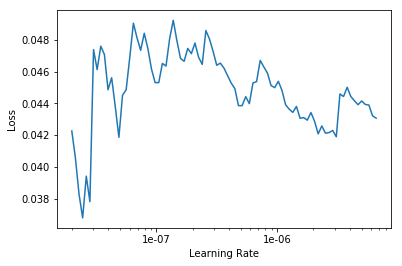

In [ ]:
learn.lr_find(start_lr = 1e-08, end_lr = 1e-05)
learn.recorder.plot()

In [ ]:
cb = OneCycleScheduler(learn, lr_max = 1e-03)

learn.fit(5, callbacks = cb)

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: ignored

Top 3:
* ResNext50: 94.87%
* DenseNet161: 94.74%
* VGG16: 94.56%

In [ ]:
class RandomErasing(object):
    """
    Class that performs Random Erasing in Random Erasing Data Augmentation by Zhong et al.
    -------------------------------------------------------------------------------------
    probability: The probability that the operation will be performed.
    sl: min erasing area
    sh: max erasing area
    r1: min aspect ratio
    mean: erasing value
    -------------------------------------------------------------------------------------
    """
    def __init__(self, probability = 0.5, sl = 0.02, sh = 0.4, r1 = 0.3, mean = [0.4914, 0.4822, 0.4465]):
        self.probability = probability
        self.mean = mean
        self.sl = sl
        self.sh = sh
        self.r1 = r1

    def __call__(self, img):
        if random.uniform(0, 1) > self.probability:
            return img

        for attempt in range(100):
            area = img.size()[1] * img.size()[2]
            target_area = random.uniform(self.sl, self.sh) * area
            aspect_ratio = random.uniform(self.r1, 1/self.r1)

            h = int(round(math.sqrt(target_area * aspect_ratio)))
            w = int(round(math.sqrt(target_area / aspect_ratio)))

            if w < img.size()[2] and h < img.size()[1]:
                x1 = random.randint(0, img.size()[1] - h)
                y1 = random.randint(0, img.size()[2] - w)
                if img.size()[0] == 3:
                    img[0, x1:x1+h, y1:y1+w] = self.mean[0]
                    img[1, x1:x1+h, y1:y1+w] = self.mean[1]
                    img[2, x1:x1+h, y1:y1+w] = self.mean[2]
                else:
                    img[0, x1:x1+h, y1:y1+w] = self.mean[0]
                return img

        return img

In [ ]:
# taking the mean and std values from ImageNet training for normalization
mean_values = [0.3297, 0.3819, 0.3637]
std_values = [0.1816, 0.1887, 0.1877]

train_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize(mean_values, std_values),
    RandomErasing(probability = 0.5, sl = 0.01, sh = 0.2)
])

test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize(mean_values, std_values)
])

trainset = FashionMNIST(root = './data', train = True, download = True, transform = train_transform)
trainloader = DataLoader(trainset, batch_size = 32, shuffle = True, num_workers = 2)

testset = FashionMNIST(root = './data', train = False, download = True, transform = test_transform)
testloader = DataLoader(testset, batch_size = 32, shuffle = False, num_workers = 2)

dataloaders = {'train': trainloader,
               'val'  : testloader}
dataset_sizes = {'train': len(trainset),
                 'val'  : len(testset)}

In [ ]:
ResNext50 = models.resnext50_32x4d(pretrained = True).to(device)

# Observe that all parameters are being optimized
optimizer = optim.SGD(ResNext50.parameters(), lr = 0.001, momentum = 0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

# Train the model
ResNext50_model = train_model(ResNext50, criterion, optimizer, exp_lr_scheduler, num_epochs = 25)

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

KeyboardInterrupt: ignored

In [ ]:
denseNet161 = models.densenet161(pretrained = True).to(device)

# Observe that all parameters are being optimized
optimizer = optim.SGD(denseNet161.parameters(), lr = 0.001, momentum = 0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

# Train the model
denseNet161_model = train_model(denseNet161, criterion, optimizer, exp_lr_scheduler, num_epochs = 25)

NameError: ignored

In [ ]:
VGG16 = models.vgg16(pretrained = True).to(device)

# Observe that all parameters are being optimized
optimizer = optim.SGD(VGG16.parameters(), lr = 0.001, momentum = 0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

# Train the model
VGG16_model = train_model(VGG16, criterion, optimizer, exp_lr_scheduler, num_epochs = 25)

In [ ]:
torch.save(ResNext50_model.state_dict(), 'drive/app/ResNext50RE_Img128.pth')
#torch.save(denseNet161_model.state_dict(), 'drive/app/DenseNet161RE_Img128.pth')
#torch.save(VGG16_model.state_dict(), 'drive/app/VGG16RE_Img128.pth')

## Inception
See [Rethinking the Inception Architecture for Computer Vision](https://arxiv.org/abs/1512.00567).

$\textbf{Important}$: In contrast to the other models the inception v3 expects tensors with a size of N x 3 x 299 x 299, so ensure your images are sized accordingly.

This is a problem because our dataset has 28 x 28 sized images. This means we will be sacrificing a lot of quality in the data. But let's try it anyway just to see how it performs.

## GoogLeNet
See [Going Deeper with Convolutions](https://arxiv.org/abs/1409.4842).

## ShuffleNet
See [ShuffleNet V2: Practical Guidelines for Efficient CNN Architecture Design](https://arxiv.org/abs/1807.11164).

## WideResNet
See [Wide Residual Networks](https://arxiv.org/abs/1605.07146).